## SECOND EXPERIMENT

Для второго эксперимента мы использовали подход, представленный по этой [ссылке](https://colmap.github.io/faq.html#reconstruct-sparse-dense-model-from-known-camera-poses) в документации COLMAP. 

Суть данного эксперимента заключается в том, что мы будем использовать возможности аппарата PixSfM, а именно featuremetric KA до построения SfM и feature-reference BA после построения SfM.


### Reconstruct sparse/dense model from known camera poses 

| COLMAP | PixSfM | 
| --- | --- |
| 1)  Создать три файла cameras.txt, images.txt, point3D.txt в одной папке. | 1) Создать три файла cameras.txt, images.txt, point3D.txt в одной папке |
| 2) Создать пустой файл points3D.txt | 2) Создать пустой файл points3D.txt |
| 3) В файле images.txt каждая вторая строка для изображения должна быть пустой, cameras.txt должен иметь всю инфу. | 3) В файле images.txt каждая вторая строка для изображения должна быть пустой, cameras.txt должен иметь всю инфу. |
| 4) Заполняем БД инфой о камерах и изображениях. | 4) Заполняем БД инфой о камерах и изображениях.|
| 5) Выполняем feature extraction при помощи COLMAP и записываем фичи в БД. | 5)  Выполняем feature extraction при помощи **hloc**.|
| 6) Выполняем exhausting matching. | 6) Выполняем exhausting matching при помощи **hloc**.|
| | 7) Выполняем **Featuremetric KA** (Keypoint Adjustment), запись улучшенных features в БД. |
| 7) Построение SfM (этап triangulation).| 8) Построение SfM (этап triangulation).|
|  | 9) Выполняем **feature-reference BA** (Bundle Adjustment).|


# Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars

from pathlib import Path
import pycolmap
import sys

sys.path.append("/workspace/pixel-perfect-sfm/")
sys.path.append("/workspace/pixel-perfect-sfm/Hierarchical-Localization")

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from hloc.utils.read_write_model import  write_next_bytes, Point3D, Image, read_images_text, \
        read_points3D_binary, write_points3D_binary, write_images_binary, read_images_binary, \
        read_cameras_text

from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect

from utils import modified_write_points3D_text

import numpy as np

import open3d as o3d
assert o3d.__version__ == '0.15.2', 'The version 0.15.2 is required!'

# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Setup

В **object_name** необходимо задать имя объекта, над которым вы хотите провести эксперимент.

**check_for_calibrated_images** - булевая переменная, по которой мы выбираем какие поз камер использовать (менее точные (True) или точные (False))

**delete_previous_output** - если True, то удаляет все предыдущие файлы в папке outputs. Использовать супер осторожно.

**has_cache** - если True, то у Вас уже существует файл с feature maps и он сохранен в папке cache_init. Это файл с feature maps Вы получаете только тогда, когда вы уже сделали featuremetric KA или BA для одного из ваших экспериментов.

**show_visualization** - если True, то показывает визуализацию результата эксперимента (3d pointcloud, задектированные keypoints (features) и final reprojections для какого-то изображения).

**refine_BA_cameras_intrinsics** - если True, то в эксперименте BA будет менять внутренние параметры камеры, если False, то мы сохраняем GT внутренние параметры камеры (инфа будет взята из файла **cameras_init**)

In [2]:
object_name = 'dragon'

check_for_calibrated_images = False
refine_BA_cameras_intrinsics = False

delete_previous_output = False

has_cache = True
show_visualization = False

**images_init** - путь к файлу images.txt с известными позами камер (каждая вторая строка пустая)

**calibrated_images_init** - путь к файлу images.txt c известнами позами камер (но менее точные)

**cameras_init** - путь к файлу cameras.txt

**images** - путь к папке с изображениями для реконструкции

**outputs** - путь к папке со всеми результатами

**cache_init** - путь к кэш-файлу, его мы получаем во время того, когда делаем KA или BA. В этот файле хранятся featuremaps после  dense feature extraction. В среднем на одну картинку размером 2368х1952 уходит 3 минуты. Этот файл вообще нельзя трогать, поэтому мы копируем его в папку outputs для своего эксперимента и продолжаем работу.

**cache_path** - тот же файл, что cache_init, с которым мы теперь будем работать во время эксперимента.

**sfm_pairs** - файл с названиями пар изображений на каждой строке

**features** - файл с features для каждой картинки, извлеченными при помощи feature_conf

**matches** - файл с matches для каждой пары картинок, извлеченными при помощи matcher_conf

In [3]:
root = Path('/workspace')

images_init = root / f'datasets/sk3d/dataset/{object_name}/tis_right/rgb/images.txt'
calibrated_images_init = root / 'datasets/sk3d/dataset/calibration/tis_right/rgb/images.txt' # менее точные

cameras_init = root / 'datasets/sk3d/dataset/calibration/tis_right/rgb/cameras.txt'

images = root / f'datasets/sk3d/dataset/{object_name}/tis_right/rgb/undistorted/ambient@best'

outputs = root / f'pixel-perfect-sfm/outputs/{object_name}/experiment_2/'

if delete_previous_output:
    !rm -rf $outputs 
    
outputs.mkdir(parents=True, exist_ok=True)    
    
if has_cache:
    cache_init = root / f'pixel-perfect-sfm/outputs/caches/{object_name}/s2dnet_featuremaps_sparse.h5'
    !cp -r $cache_init $outputs
    cache_path = outputs / 's2dnet_featuremaps_sparse.h5'    

sfm_pairs = outputs / 'pairs-sfm.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

**exp2_dir** - папка, в которой будет сохранен результат второго эксперимента.

In [4]:
exp_name = "exp_not_refine_cam_params"
if refine_BA_cameras_intrinsics: exp_name = "exp_refine_cam_params"

exp2_dir = outputs / exp_name
exp2_dir.mkdir(parents=True, exist_ok=True)

if check_for_calibrated_images:
    images_init = calibrated_images_init
    
    exp2_dir = outputs / f"calibrated/{exp_name}"
    exp2_dir.mkdir(parents=True, exist_ok=True)
    
else:
    exp2_dir = outputs / f"refined/{exp_name}"
    exp2_dir.mkdir(parents=True, exist_ok=True)

# 3D mapping and refinement

Здесь описаны возможности для настройки [**extract_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/extract_features.py#L21)

Здесь описаны возможности для настройки [**match_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/match_features.py#L17)

Здесь описан пайплайн того, как можно использовать свои кастомные [**local features**, **matcher**, **image retrieval**](https://github.com/cvg/Hierarchical-Localization/tree/91f40bfd765add3b59ba7376f8579d8829f7fa78#using-your-own-local-features-or-matcher).


In [5]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

Здесь мы проверяем какие изображения мы будем использовать для реконструкции.

100 mapping images


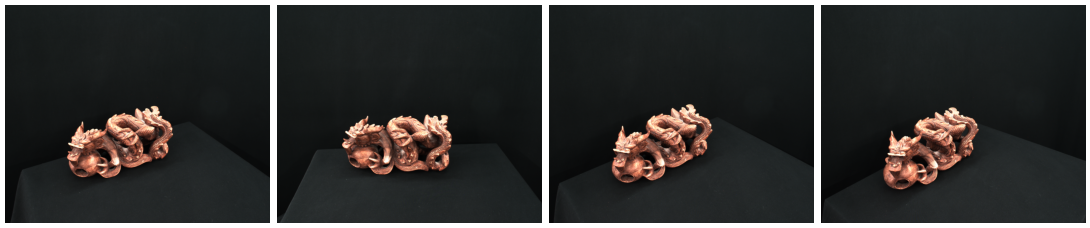

In [6]:
references = [str(p.relative_to(images)) for p in images.iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references[:4]], dpi=50)

**extract_features** - данная функция получает на вход *feature_conf*, *images* (путь к папке с изображениями), *image_list* (список тех изображений, которые вы хотите использовать для feature exctraction), *feature_path* (путь к файлу, где будет сохранен результат). На выходе получаем файл (**features**) с извлеченными features. Если **features** существует, то пропускается.

**pairs_from_exhaustive** - данная функция получает на вход *sfm_pairs* (путь к файлу, где будет сохранен результат), *image_list* (список тех изображений, при помощи которых вы сделаете exhaustive pairs.) На выходе получаем файл (**sfm_pairs**) с парами изображений.  Если **sfm_pairs** существует, то пропускается.

**match_features** - данная функция получает на вход *matcher_conf*, *sfm_pairs* (путь к файлу, где хранятся пары изображений после exhaustive pairing), *features* (путь к файлу, где хранятся извлеченный features для каждого изображения), *matches* (путь к файлу, где хранятся matches для каждой пары изображения). На выходе получаем файл (**matches**) с matches для каждой пары изображений . Если **match_features** существует, то пропускается.



In [7]:
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/features.h5 $outputs
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/matches.h5 $outputs
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/pairs-sfm.txt $outputs

Ниже клетка может выполняться от получаса до часа (в зависимости от нагруженности).

Features extraction - 1 минута.

Features matching - 35-50 минут.

In [8]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features) 
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches); 

[2022/10/06 16:51:34 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/10/06 16:51:35 hloc INFO] Skipping the extraction.
[2022/10/06 16:51:35 hloc INFO] Found 4950 pairs.
[2022/10/06 16:51:35 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/10/06 16:51:35 hloc INFO] Skipping the matching.


Копируем файлы images.txt, cameras.txt в папку для второго эксперимента. В этой папке мы должны иметь три файла (images.txt, cameras.txt и пустой файл point3d.txt).

In [9]:
!cp -r $images_init $exp2_dir
print("images.txt copied!")

!cp -r $cameras_init $exp2_dir
print("cameras.txt copied!")

!touch $exp2_dir/points3D.txt
print("points3D.txt created!")

!ls $exp2_dir

images.txt copied!
cameras.txt copied!
points3D.txt created!
cameras.txt  images.txt  points3D.txt


Смотрим при помощи **pycolmap** информацию о полученной на данной момент реконструкции.

In [10]:
check_model = pycolmap.Reconstruction(exp2_dir)
print(check_model.summary())

Reconstruction:
	num_reg_images = 100
	num_cameras = 1
	num_points3D = 0
	num_observations = 0
	mean_track_length = 0
	mean_observations_per_image = 0
	mean_reprojection_error = 0


**Featuremetric KA (Keypoint Adjustment)**

В конфиге conf_KA расписана необходимая информация для того, чтобы сделать KA. В этом конфиге также указано, что вы хотите использовать cache, который находится в пути cache_path.

**keypoints_path** -  здесь будут сохранены обновленная информация по уже имеющимся keypoints (features). После KA тут уже будут сохранены новые features.

Здесь описано как можно настроить конфигурацию для КА. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

 КА выполняется ниже за 3-4 минуты.

In [11]:
from pixsfm.refine_hloc import PixSfM
from pixsfm.refine_colmap import PixSfM as PixSfM_ba

# running Keypoint Adjustment
conf_KA = {
        "dense_features": {
                "use_cache": True,
        },
        "KA": {
            "dense_features": {'use_cache': True}, 
            "split_in_subproblems": True,
            "max_kps_per_problem": 1000,  
        },
}

if not has_cache:
    conf_KA.update({
        "dense_features": {
            "use_cache": True,
            "sparse" : True,
            "dtype" : "half",
            "overwrite_cache": True,
            "load_cache_on_init": False,
            "patch_size": 8,
            "cache_format": "chunked"
        }

    })

refiner = PixSfM(conf=conf_KA)

keypoints_path = exp2_dir / "refined_keypoints.h5"

keypoints, ka_data, feature_manager = refiner.refine_keypoints(
    output_path = keypoints_path,
    image_dir = images,
    features_path = features,
    pairs_path = sfm_pairs,
    matches_path = matches,
    cache_path = cache_path,
)

if not has_cache:    
    caches = root / f'pixel-perfect-sfm/outputs/caches/exp2/{object_name}'
    caches.mkdir(parents=True, exist_ok=True)
    cache_path = outputs / 's2dnet_featuremaps_sparse.h5'
    !cp -r $cache_path $caches 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2022/10/06 16:51:41 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3060 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3060 GPU with PyTorch,

[2022/10/06 16:51:47 pixsfm INFO] Loading featuremaps from H5 File.


100%[████████████████████] 100/100 [00:00, 653.594it/s]


[2022/10/06 16:51:47 pixsfm INFO] Computing tracks...
[2022/10/06 16:51:47 pixsfm INFO] # graph nodes: 49802
[2022/10/06 16:51:47 pixsfm INFO] # graph edges: 1376794
[2022/10/06 16:51:49 pixsfm INFO] # tracks: 1531
[2022/10/06 16:51:49 pixsfm INFO] Start feature-metric keypoint adjustment.


100%[████████████████████] 49802/49802 [02:22, 349.860it/s]


[2022/10/06 16:54:12 pixsfm INFO] KA Time: 142.378s, cost change: 0.0220953 --> 0.0182264


Импортируем **hloc**. Она нам поможет создать БД, заполнить БД, сделать геометрическую верификацию, сделать триангуляцию.

In [12]:
# https://github.com/cvg/pixel-perfect-sfm/blob/main/pixsfm/refine_hloc.py

try:
    import hloc
except ImportError:
    print("Could not import hloc.")
    hloc = None

1) Создание БД

2) Импорт камер, картинок, улучшенных features, matches

3) Запись реконструкции до FMBA в папку.

Ниже клетка выполняется за 1 минуту.

In [13]:
hloc_path = exp2_dir / 'hloc'
hloc_path.mkdir(parents=True, exist_ok=True)

database_path = hloc_path / 'database.db' 
reference = pycolmap.Reconstruction(exp2_dir)   

images_txt_path = exp2_dir / 'images.txt'
images_dict = read_images_text(images_txt_path)
        
# Here I changed code and in database we have data about camera extrinsics    
image_ids = hloc.triangulation.create_db_from_model(reference, 
                                                    database_path, 
                                                    images_dict)

#Importing features into database -> keypoints table 
hloc.triangulation.import_features(image_ids, 
                                   database_path, 
                                   keypoints_path)

#Importing matches into database -> matches table
skip_geometric_verification = False
hloc.triangulation.import_matches(image_ids, 
                                  database_path, 
                                  sfm_pairs, 
                                  matches,
                                  min_match_score=None, 
                                  skip_geometric_verification=skip_geometric_verification)

verbose, estimate_two_view_geometries = True, False

if not skip_geometric_verification:
        if estimate_two_view_geometries:
            hloc.triangulation.estimation_and_geometric_verification(database_path, 
                                                                     sfm_pairs, 
                                                                     verbose)
        else:
            # We are doing this part to add data to two_view_geometries table
            hloc.triangulation.geometric_verification(
                image_ids, 
                reference, 
                database_path, 
                keypoints_path, 
                sfm_pairs, 
                matches)
            
reconstruction = hloc.triangulation.run_triangulation(hloc_path, 
                                                      database_path, 
                                                      images, 
                                                      reference, 
                                                      verbose)

print(reconstruction.summary())  

# Saving result to a folder
reconstruction.write(str(hloc_path))

!mkdir -p $hloc_path/model_txt/

!colmap model_converter \
    --input_path $hloc_path \
    --output_path $hloc_path/model_txt/\
    --output_type TXT

[2022/10/06 16:54:12 hloc INFO] Images info from images dictionary.
[2022/10/06 16:54:13 hloc INFO] Importing features into the database...


  0%|          | 0/100 [00:00<?, ?it/s]

[2022/10/06 16:54:13 hloc INFO] Importing matches into the database...


  0%|          | 0/4950 [00:00<?, ?it/s]

[2022/10/06 16:54:20 hloc INFO] Performing geometric verification of the matches...


  0%|          | 0/99 [00:00<?, ?it/s]

[2022/10/06 16:54:44 hloc INFO] mean/med/min/max valid matches 81.52/83.00/36.84/96.23%.
[2022/10/06 16:54:44 hloc INFO] Running 3D triangulation...



Loading database

Loading cameras... 1 in 0.001s
Loading matches... 4950 in 0.024s
Loading images... 100 in 0.005s (connected 100)
Building correspondence graph... in 0.152s (ignored 1)

Elapsed time: 0.003 [minutes]


Triangulating image #1 (0)

  => Image sees 0 / 542 points
  => Triangulated 539 points

Triangulating image #2 (1)

  => Image sees 396 / 519 points
  => Triangulated 119 points

Triangulating image #3 (2)

  => Image sees 410 / 528 points
  => Triangulated 114 points

Triangulating image #4 (3)

  => Image sees 432 / 517 points
  => Triangulated 81 points

Triangulating image #5 (4)

  => Image sees 424 / 518 points
  => Triangulated 92 points

Triangulating image #6 (5)

  => Image sees 436 / 509 points
  => Triangulated 72 points

Triangulating image #7 (6)

  => Image sees 424 / 501 points
  => Triangulated 75 points

Triangulating image #8 (7)

  => Image sees 417 / 480 points
  => Triangulated 63 points

Triangulating image #9 (8)

  => Image sees 407 / 477 point


  => Image sees 492 / 499 points
  => Triangulated 5 points

Triangulating image #33 (32)

  => Image sees 465 / 474 points
  => Triangulated 8 points

Triangulating image #34 (33)

  => Image sees 475 / 484 points
  => Triangulated 7 points

Triangulating image #35 (34)

  => Image sees 438 / 456 points
  => Triangulated 18 points

Triangulating image #36 (35)

  => Image sees 426 / 458 points
  => Triangulated 31 points

Triangulating image #37 (36)

  => Image sees 424 / 457 points
  => Triangulated 33 points

Triangulating image #38 (37)

  => Image sees 440 / 466 points
  => Triangulated 24 points

Triangulating image #39 (38)

  => Image sees 459 / 472 points
  => Triangulated 12 points

Triangulating image #40 (39)

  => Image sees 472 / 483 points
  => Triangulated 11 points

Triangulating image #41 (40)

  => Image sees 501 / 512 points
  => Triangulated 10 points

Triangulating image #42 (41)

  => Image sees 508 / 518 points
  => Triangulated 9 points

Triangulating image #

Triangulating image #65 (64)

  => Image sees 494 / 505 points
  => Triangulated 8 points

Triangulating image #66 (65)

  => Image sees 497 / 507 points
  => Triangulated 10 points

Triangulating image #67 (66)

  => Image sees 475 / 484 points
  => Triangulated 9 points

Triangulating image #68 (67)

  => Image sees 488 / 497 points
  => Triangulated 9 points

Triangulating image #69 (68)

  => Image sees 464 / 485 points
  => Triangulated 16 points

Triangulating image #70 (69)

  => Image sees 478 / 494 points
  => Triangulated 10 points

Triangulating image #71 (70)

  => Image sees 447 / 475 points
  => Triangulated 22 points

Triangulating image #72 (71)

  => Image sees 462 / 475 points
  => Triangulated 11 points

Triangulating image #73 (72)

  => Image sees 476 / 487 points
  => Triangulated 8 points

Triangulating image #74 (73)

  => Image sees 467 / 475 points
  => Triangulated 7 points

Triangulating image #75 (74)

  => Image sees 468 / 478 points
  => Triangulated 5 po

Triangulating image #98 (97)

  => Image sees 464 / 475 points
  => Triangulated 8 points

Triangulating image #99 (98)

  => Image sees 470 / 484 points
  => Triangulated 14 points

Triangulating image #100 (99)

  => Image sees 430 / 465 points
  => Triangulated 33 points

Retriangulation

  => Completed observations: 0
  => Merged observations: 9701

Bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.259461e+06    0.00e+00    2.64e+06   0.00e+00   0.00e+00  1.00e+04        0    1.13e-02    4.52e-02
   1  2.101265e+06    1.58e+05    8.11e+04   3.30e-01   9.99e-01  3.00e+04        0    1.52e-02    6.10e-02
   2  2.101107e+06    1.58e+02    2.48e+02   4.69e-02   9.99e-01  9.00e+04        0    1.28e-02    7.43e-02
   3  2.101107e+06    3.64e-02    7.06e-01   3.13e-03   1.00e+00  2.70e+05        0    1.33e-02    8.81e-02


Bundle adjustment report
------------------------
    Residuals : 97654
   Paramete

Проверяем те же ли параметры камер получились.

In [14]:
# compare images old and new, compare cameras old and new
images_old = read_images_text(exp2_dir / 'images.txt')
images_new = read_images_binary(hloc_path / 'images.bin')

for i in range(1, 101):
    if np.array_equal(images_old[i].tvec, images_new[i].tvec) != True: print("NOT OK!"); break
    if np.allclose(np.array(images_old[i].qvec, dtype=np.float32), 
                          np.array(images_new[i].qvec, dtype=np.float32)) != True: print("NOT OK!"); break;

**Featuremetric BA (Bundle Adjustment)**

В конфиге conf_BA расписана необходимая информация для того, чтобы сделать BA. В этом конфиге также указано, что вы хотите использовать cache, который находится в пути cache_path.

Здесь описано как настроить конфигурацию для ВА. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

Здесь ВА выполняется за 1.5-2 минуты.

In [15]:
# running featuremetric BA
if refine_BA_cameras_intrinsics:
    conf_BA = {
            "dense_features": {
                    "use_cache": True,
            },

            "BA": {
                "dense_features": {'use_cache': True}, 
                "apply": True
            }
    }
else:
    conf_BA = {
            "dense_features": {
                    "use_cache": True,
            },

            "BA": {
                "dense_features": {'use_cache': True}, 
                "apply": True,
                "optimizer": {
                      "refine_focal_length": False,  # whether to optimize the focal length
                      "refine_principal_point": False,  # whether to optimize the principal points
                      "refine_extra_params": False,  # whether to optimize distortion parameters
                      "refine_extrinsics": True,  # whether to optimize the camera poses
                }
            }
    }    
    
refiner = PixSfM_ba(conf=conf_BA)

reconstruction, ba_data, feature_manager2 = refiner.refine_reconstruction(
    output_path = exp2_dir / 'hloc/model',
    input_path = exp2_dir / 'hloc',
    image_dir = images,
    cache_path = cache_path,
)

print(reconstruction.summary())

!mkdir -p $exp2_dir/hloc/model/model_txt/

!colmap model_converter \
    --input_path $exp2_dir/hloc/model \
    --output_path $exp2_dir/hloc/model/model_txt/\
    --output_type TXT

[2022/10/06 16:55:09 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/10/06 16:55:09 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': True}


[2022/10/06 16:55:10 pixsfm INFO] Loading featuremaps from H5 File.


100%[████████████████████] 100/100 [00:00, 813.008it/s]


[2022/10/06 16:55:10 pixsfm INFO] Loading patches from H5 File.


100%[████████████████████] 45009/45009 [00:01, 30370.4it/s]


[2022/10/06 16:55:11 pixsfm INFO] Extracting references.


100%[████████████████████] 2496/2496 [00:02, 912.948it/s]


[2022/10/06 16:55:14 pixsfm INFO] Reference Extraction Time: 2.73384s
[2022/10/06 16:55:14 pixsfm INFO] Start feature-reference bundle adjustment.


100%[████████████████████] 101/101 [00:50, 1.98928it/s]


[2022/10/06 16:56:05 pixsfm INFO] BA Time: 50.7846s, cost change: 0.0193779 --> 0.0188107
Reconstruction:
	num_reg_images = 100
	num_cameras = 1
	num_points3D = 2496
	num_observations = 45009
	mean_track_length = 18.0325
	mean_observations_per_image = 450.09
	mean_reprojection_error = 1.28782


# Visualization

In [16]:
fig3d = init_figure()

args = dict(max_reproj_error=3.0, 
            min_track_length=2, 
            cs=0.01) #camera size

plot_reconstruction(fig3d, reconstruction, 
                    color='rgba(0, 255, 0, 0.5)', 
                    name="refined", **args)

if show_visualization:
    fig3d.show()

In [17]:
refined = reconstruction

img = refined.images[refined.reg_image_ids()[0]]
cam = refined.cameras[img.camera_id]

fig = init_image(images / img.name)    

plot_points2D(fig, [p2D.xy for p2D in img.points2D if p2D.has_point3D()])
plot_points2D(fig, cam.world_to_image(img.project(refined)), color='rgba(255, 0, 0, 0.5)')

if show_visualization:
    fig.show()